# Wearable Stress and Affect Detection (WESAD) Exploratory Data Analysis
## https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29#

'''
Philip Schmidt, Attila Reiss, Robert Duerichen, Claus Marberger and Kristof Van Laerhoven. 2018. 
Introducing WESAD, a multimodal dataset for Wearable Stress and Affect Detection. 
In 2018 International Conference on Multimodal Interaction (ICMI '18), October 16-20, 2018, Boulder, CO, USA. ACM, New York, NY, USA, 9 pages.
'''

This dataset is part of the UCI ML Data repository and contains high granularity data (700 Hz) of 15 test subjects from chest worn sensors (RespiBAN) in the form of:
  - ECG
  - EDA
  - EMG
  - Body Temp
  - Accelorometer
  - Respiration %
  
Contains data at lower granularity from wrist worn (non dominant) Empatica device in the form of:
  - ACC
  - BVP
  - EDA
  - Body Temp

Wearable data generation has exploded in recent years, and with it the analysis of it. Time series data can yield very interesting insights and can paint a picture of people's health that they would not be able to see themselves.

Let's explore this data and see what we find.

## Import Packages and Configure Settings

In [1]:
# Do this first so we can have plots in the cells
%matplotlib inline
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import pickle

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [3]:
plt.style.use('ggplot')

In [4]:
# Before we start, let's fix the row/column displays so we can see all rows/columns
# Set ipython's max row display
pd.set_option('display.max_row', 100)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 100)

# Also for numpy, since we will be creating arrays off of the data
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

# Suppress scientific notation, show as decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Do this to have jupyter notebook displayed in FULL
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Get Data

In [5]:
# This is from the data_etl.py script
"""
According to the README:
The double-tap signal pattern was used to manually synchronise the two devices' raw data. The result is provided in the files SX.pkl, one file per subject. This file is a dictionary, with the following keys:
- 'subject': SX, the subject ID
- 'signal': includes all the raw data, in two fields:
  - 'chest': RespiBAN data (all the modalities: ACC, ECG, EDA, EMG, RESP, TEMP)
  - 'wrist':EmpaticaE4data(all the modalities:ACC,BVP,EDA,TEMP)
- 'label': ID of the respective study protocol condition, sampled at 700 Hz. The following IDs
are provided: 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
"""

# Study protocal conditions (label) mapping
label_map = {
    0: 'not defined / transient',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
}


# Read in WESAD datasets by subject and unpickle
subject_dct = {}
path = '../../data/WESAD'
filenames = glob.glob(os.path.join(path,'*/*.pkl'))
for file in filenames:
    # Had to use 'latin1' as the encoding due to Python 2/3 pickle incompatibility
    # https://stackoverflow.com/questions/11305790/pickle-incompatibility-of-numpy-arrays-between-python-2-and-3
    unpickled_file = pickle.load(open(file,'rb'), encoding='latin1')
    # Grab relevant info
    subject_id = unpickled_file['subject']
    print('processing subject',subject_id)
    chest_dct = unpickled_file['signal']['chest']
    wrist_dct = unpickled_file['signal']['wrist']

    # Process the chest dictionary first as it is more straight forward
    # Since the 'ACC' column contains 3 dimensional tuples, it needs to be processed separately due to pandas expecting the same format for all columns
    # Going to create dictionaries without that column to turn into a dataframe, then add the 'ACC' values later
    tmp_chest_dct = dict((k, chest_dct[k].ravel()) for k in list(chest_dct.keys()) if k not in ['ACC'])
    tmp_chest_df = pd.DataFrame(tmp_chest_dct) # Contains everything except ACC
    tmp_acc_df = pd.DataFrame(chest_dct['ACC'],columns=['ACC_X','ACC_Y','ACC_Z']) # Manually declare keys, otherwise shows up as 0,1,2
    final_chest_df = pd.concat([tmp_chest_df,tmp_acc_df],axis=1)

    # Process wrist dictionary, which will take more care because the samplying frequencies were different 
    # Meaning the number of data points collected for each feature is different (higher frequency equals more data points)
    # Basically this one just needs to be processed manually
    wrist_acc_df = pd.DataFrame(wrist_dct['ACC'],columns=['ACC_X','ACC_Y','ACC_Z'])
    wrist_bvp_df = pd.DataFrame(wrist_dct['BVP'],columns=['BVP'])
    wrist_eda_df = pd.DataFrame(wrist_dct['EDA'],columns=['EDA'])
    wrist_temp_df = pd.DataFrame(wrist_dct['TEMP'],columns=['TEMP'])

    # Add labels as a separate object to be returned
    # While the time granularity is the same as the chest data, I'm not sure yet how to use it with the wrist data
    # So will just keep it separate and add as needed
    labels_df = pd.DataFrame(unpickled_file['label'],columns=['label'])
    labels_df['mapped_label'] = labels_df['label'].map(label_map)
    labels_df['SUBJECT_ID'] = subject_id
    
    # Add subject id to all dataframes
    for df in [final_chest_df, wrist_acc_df, wrist_bvp_df, wrist_eda_df, wrist_temp_df]:
        df['SUBJECT_ID'] = subject_id

    subject_dct[subject_id] = {
        'chest_df': final_chest_df,
        'wrist_dfs': {
            'wrist_acc_df': wrist_acc_df,
            'wrist_bvp_df': wrist_bvp_df,
            'wrist_eda_df': wrist_eda_df,
            'wrist_temp_df': wrist_temp_df,
        },
        'labels': labels_df,
    }

# Return dictionary (TO DO: more preprocessing if possible)
print(subject_dct)

processing subject S5
processing subject S2
processing subject S3
processing subject S4
processing subject S17
processing subject S10
processing subject S11
processing subject S16
processing subject S8
processing subject S6
processing subject S7
processing subject S9
processing subject S13
processing subject S14
processing subject S15
{'S5': {'chest_df':            ECG    EMG    EDA   Temp   Resp  ACC_X  ACC_Y  ACC_Z SUBJECT_ID
0       -0.276  0.017  3.888 34.120  0.044  0.861  0.074  0.857         S5
1       -0.230  0.015  3.913 34.143  0.032  0.846  0.078  0.857         S5
2       -0.195  0.015  3.873 34.135  0.015  0.841  0.087  0.757         S5
3       -0.164 -0.004  3.883 34.137 -0.063  0.842  0.099  0.578         S5
4       -0.135  0.018  3.887 34.118  0.017  0.855  0.098  0.333         S5
...        ...    ...    ...    ...    ...    ...    ...    ...        ...
4380595 -0.008  0.009 10.231 34.971  7.071  0.909 -0.058 -0.124         S5
4380596 -0.001 -0.004 10.231 34.900  7.045 

In [6]:
# Choose random subject to inspect 
# Since there were two participants (S1 & S12) whose data had to be removed, pick another number if we get those two
from random import randint
removed_subjects = [1,12]
valid = False
while not valid:
    rand = randint(1,17)
    if rand not in removed_subjects:
        valid = True
    else:
        print('Picked removed subject',rand,'trying again')

rand_id = 'S' + str(rand)
subject_dct[rand_id]
#pd.concat([subject_dct['S13']['labels'],subject_dct['S13']['chest_df']['SUBJECT_ID']],axis=1)

{'chest_df':            ECG    EMG   EDA   Temp   Resp  ACC_X  ACC_Y  ACC_Z SUBJECT_ID
 0       -0.026 -0.016 1.362 33.493  0.691  0.830  0.312  1.147        S15
 1       -0.013 -0.014 1.358 33.448  0.694  0.831  0.297  1.239        S15
 2        0.003 -0.013 1.345 33.481  0.696  0.845  0.261  1.245        S15
 3        0.008 -0.003 1.353 33.499  0.690  0.867  0.207  1.160        S15
 4        0.007 -0.001 1.344 33.493  0.682  0.900  0.164  1.030        S15
 ...        ...    ...   ...    ...    ...    ...    ...    ...        ...
 3676395 -0.166  0.005 4.121 34.421 -1.039  0.921  0.060 -0.186        S15
 3676396 -0.163 -0.004 4.119 34.375 -1.065  0.921  0.062 -0.181        S15
 3676397 -0.138 -0.011 4.120 34.335 -1.100  0.923  0.061 -0.178        S15
 3676398 -0.112 -0.018 4.123 34.389 -1.106  0.922  0.063 -0.175        S15
 3676399 -0.092 -0.020 4.130 34.421 -1.079  0.921  0.063 -0.165        S15
 
 [3676400 rows x 9 columns],
 'wrist_dfs': {'wrist_acc_df':          ACC_X   ACC_Y   A

# Quick Insights Using Pandas DataFrame .describe() Method
The built in describe() method in Pandas dataframes is a great way to get an initial idea of the distributions of the numeric features in your data. For example, we can quickly get an idea whether the data is skewed or not by comparing the mean to the median (or 50th percentile). By looking at the other percentiles (25%, 75%), we can also see HOW skewed the data is in either direction.

Note that I will do this by combining all data and describing it in aggregate; we will lose information this way because we are removing the time series element. We will revisit this later.

Let's give it a go!

### Chest Monitor Data

We need to concatenate all data together to do this; its been a pain trying to do this due to all the data that's required to be joined.

Found this [article](https://towardsdatascience.com/speeding-up-pandas-dataframe-concatenation-748fe237244e) that describes how the pandas concatenate function is very costly and uses the index to do the join. By dropping the index the join becomes much faster.

Will demonstrate this below.

In [ ]:
subject_ids = list(subject_dct.keys())
display(subject_ids)

In [127]:
# First do without dropping index
import time

t0 = time.time()
'''
chest_data = []
label_data = []
for subject_id in subject_ids:
    chest_data.append(subject_dct[subject_id]['chest_df'])
    label_data.append(subject_dct[subject_id]['labels']['label'])
all_subjects_chest_data_df = pd.concat(chest_data)
all_subjects_labels_df = pd.concat(label_data)
all_subjects_chest_df = pd.concat([all_subjects_chest_data_df.reset_index(drop=True),all_subjects_labels_df.reset_index(drop=True)],axis=1)
'''

all_subjects_chest_data_df = pd.concat([subject_dct[subject_id]['chest_df'] for subject_id in list(subject_dct.keys())])
all_subjects_labels_df = pd.concat([subject_dct[subject_id]['labels']['label'] for subject_id in list(subject_dct.keys())])
all_subjects_chest_df = pd.concat([all_subjects_chest_data_df,all_subjects_labels_df.reset_index(drop=True)],axis=1)

t1 = time.time()

total = t1-t0
print('Joining without dropping the index first took', total, 'seconds to complete.')

Joining without dropping the index first took 63.9330267906189 seconds to complete.


In [128]:
all_subjects_chest_df

,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z,SUBJECT_ID,label
0,-0.276,0.017,3.888,34.120,0.044,0.861,0.074,0.857,S5,0
1,-0.230,0.015,3.913,34.143,0.032,0.846,0.078,0.857,S5,0
2,-0.195,0.015,3.873,34.135,0.015,0.841,0.087,0.757,S5,0
3,-0.164,-0.004,3.883,34.137,-0.063,0.842,0.099,0.578,S5,0
4,-0.135,0.018,3.887,34.118,0.017,0.855,0.098,0.333,S5,0
...,...,...,...,...,...,...,...,...,...,...
60807595,-0.166,0.005,4.121,34.421,-1.039,0.921,0.060,-0.186,S15,0
60807596,-0.163,-0.004,4.119,34.375,-1.065,0.921,0.062,-0.181,S15,0
60807597,-0.138,-0.011,4.120,34.335,-1.100,0.923,0.061,-0.178,S15,0
60807598,-0.112,-0.018,4.123,34.389,-1.106,0.922,0.063,-0.175,S15,0


In [40]:
# Now do the join with dropping the index before concatenating 
import time

t0 = time.time()
'''
chest_data = []
label_data = []
for subject_id in subject_ids:
    chest_data.append(subject_dct[subject_id]['chest_df'])
    label_data.append(subject_dct[subject_id]['labels']['label'])
all_subjects_chest_data_df = pd.concat(chest_data)
all_subjects_labels_df = pd.concat(label_data)
all_subjects_chest_df = pd.concat([all_subjects_chest_data_df.reset_index(drop=True),all_subjects_labels_df.reset_index(drop=True)],axis=1)
'''

all_subjects_chest_data_df = pd.concat([subject_dct[subject_id]['chest_df'] for subject_id in list(subject_dct.keys())])
all_subjects_labels_df = pd.concat([subject_dct[subject_id]['labels']['label'] for subject_id in list(subject_dct.keys())])
all_subjects_chest_df = pd.concat([all_subjects_chest_data_df.reset_index(drop=True),all_subjects_labels_df.reset_index(drop=True)],axis=1)

t1 = time.time()

total = t1-t0
print('Joining with dropping the first index took', total, 'seconds to complete.')

Joining with dropping the first index took 25.596898078918457 seconds to complete.


In [44]:
all_subjects_chest_df

,index,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z,SUBJECT_ID
0,0,-0.276,0.017,3.888,34.120,0.044,0.861,0.074,0.857,S5
1,1,-0.230,0.015,3.913,34.143,0.032,0.846,0.078,0.857,S5
2,2,-0.195,0.015,3.873,34.135,0.015,0.841,0.087,0.757,S5
3,3,-0.164,-0.004,3.883,34.137,-0.063,0.842,0.099,0.578,S5
4,4,-0.135,0.018,3.887,34.118,0.017,0.855,0.098,0.333,S5
...,...,...,...,...,...,...,...,...,...,...
60807595,3676395,-0.166,0.005,4.121,34.421,-1.039,0.921,0.060,-0.186,S15
60807596,3676396,-0.163,-0.004,4.119,34.375,-1.065,0.921,0.062,-0.181,S15
60807597,3676397,-0.138,-0.011,4.120,34.335,-1.100,0.923,0.061,-0.178,S15
60807598,3676398,-0.112,-0.018,4.123,34.389,-1.106,0.922,0.063,-0.175,S15


In [131]:
descriptive_stats = all_subjects_chest_df.drop(columns='label').describe() # Drop label since summary statistics are meaningless for it
descriptive_stats

,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z
count,60807600.000,60807600.000,60807600.000,60807600.000,60807600.000,60807600.000,60807600.000,60807600.000
mean,0.001,-0.003,4.888,33.905,0.054,0.812,-0.044,-0.259
std,0.269,0.018,3.531,1.217,4.099,0.131,0.104,0.332
min,-1.500,-1.500,0.000,-273.150,-50.000,-6.600,-6.600,-6.600
25%,-0.092,-0.010,2.329,33.614,-2.065,0.760,-0.080,-0.465
50%,-0.026,-0.003,3.719,34.170,-0.198,0.862,-0.031,-0.252
75%,0.033,0.004,7.058,34.617,2.171,0.901,0.015,-0.068
max,1.500,1.464,22.411,35.778,38.800,2.981,1.609,4.508


In [132]:
# Nice! Now can start getting an idea of what the numeric data looks like
# However, there are quite a bit of statistics here
# Let's first look at the mean, medians and percentiles
descriptive_stats.loc[['mean','std','25%','50%','75%']]

,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z
mean,0.001,-0.003,4.888,33.905,0.054,0.812,-0.044,-0.259
std,0.269,0.018,3.531,1.217,4.099,0.131,0.104,0.332
25%,-0.092,-0.010,2.329,33.614,-2.065,0.760,-0.080,-0.465
50%,-0.026,-0.003,3.719,34.170,-0.198,0.862,-0.031,-0.252
75%,0.033,0.004,7.058,34.617,2.171,0.901,0.015,-0.068


### Wrist Data (Needs to be Done Separately Due to Different Data Granularities)

In [10]:
# See what keys are in the wrist_df
subject_dct['S5']['wrist_dfs'].keys()

dict_keys(['wrist_acc_df', 'wrist_bvp_df', 'wrist_eda_df', 'wrist_temp_df'])

In [95]:
# Combine all data together and describe
all_subjects_wrist_acc_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_acc_df'] for subject_id in list(subject_dct.keys())],axis=0)
all_subjects_wrist_bvp_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_bvp_df'] for subject_id in list(subject_dct.keys())],axis=0)
all_subjects_wrist_eda_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_eda_df'] for subject_id in list(subject_dct.keys())],axis=0)
all_subjects_wrist_temp_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_temp_df'] for subject_id in list(subject_dct.keys())],axis=0)

Joining without dropping the index first took 1.2759358882904053 seconds to complete.


In [133]:
pd.concat([df.describe() for df in [all_subjects_wrist_acc_df,all_subjects_wrist_bvp_df,all_subjects_wrist_eda_df,all_subjects_wrist_temp_df]],axis=1)

,ACC_X,ACC_Y,ACC_Z,BVP,EDA,TEMP
count,2779776.000,2779776.000,2779776.000,5559552.000,347472.000,347472.000
mean,11.655,-2.276,17.709,0.002,1.802,32.598
std,44.107,28.142,29.747,65.166,2.343,1.498
min,-128.000,-128.000,-128.000,-1773.760,0.045,28.970
25%,-36.000,-19.000,-2.000,-14.930,0.336,31.550
50%,26.000,-1.000,17.000,2.120,0.831,32.710
75%,51.000,12.000,43.000,16.220,2.396,33.680
max,127.000,127.000,127.000,1789.000,15.921,35.970


# A Closer Look

## Histograms
If we really want to see how the values of a given feature are spread out and concentrated, we should plot the counts of each unique data point in each feature set.

To do this pythonically (and to cut down on unnecessary code), we will define functions that will get unique value counts of a feature passed as an input, and then use those counts and plot a quick and dirty histogram.

This way we can separately get a list of counts and analyze it by itself, as well as not have to create a ton of variables storing unique value counts of various features.

**Note: This is a great starting point to analyze numerical categorical data (i.e. labels)**

In [ ]:
# Study protocal conditions (label) mapping
label_map = {
    0: 'not defined / transient',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
}


array([[<AxesSubplot:title={'center':'ECG'}>,
        <AxesSubplot:title={'center':'EMG'}>,
        <AxesSubplot:title={'center':'EDA'}>],
       [<AxesSubplot:title={'center':'Temp'}>,
        <AxesSubplot:title={'center':'Resp'}>,
        <AxesSubplot:title={'center':'ACC_X'}>],
       [<AxesSubplot:title={'center':'ACC_Y'}>,
        <AxesSubplot:title={'center':'ACC_Z'}>,
        <AxesSubplot:title={'center':'label'}>]], dtype=object)

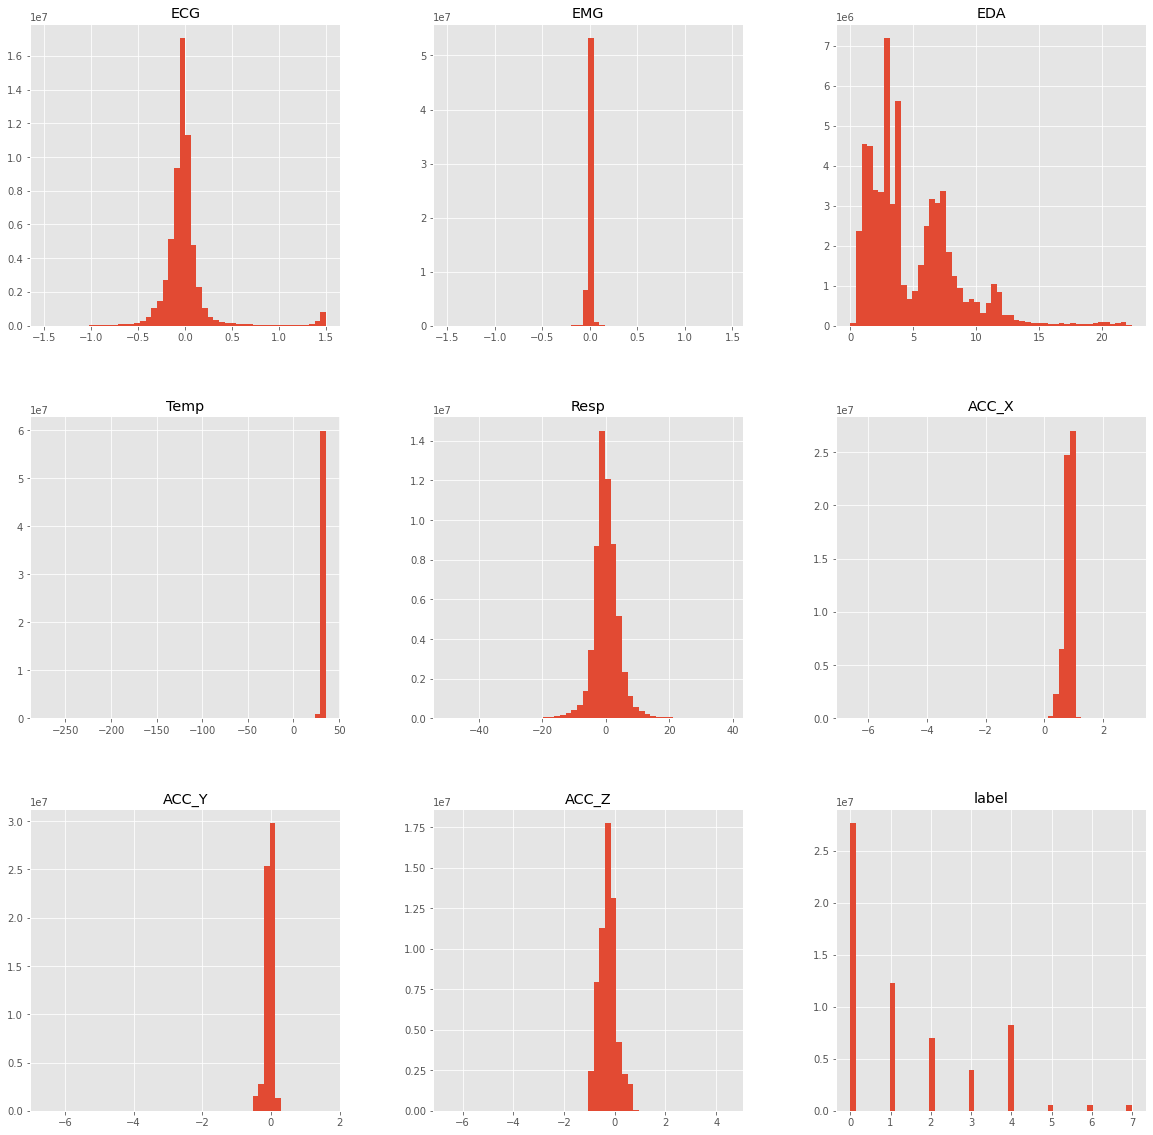

In [134]:
all_subjects_chest_df.hist(figsize=(20,20),bins=50)

array([[<AxesSubplot:title={'center':'TEMP'}>]], dtype=object)

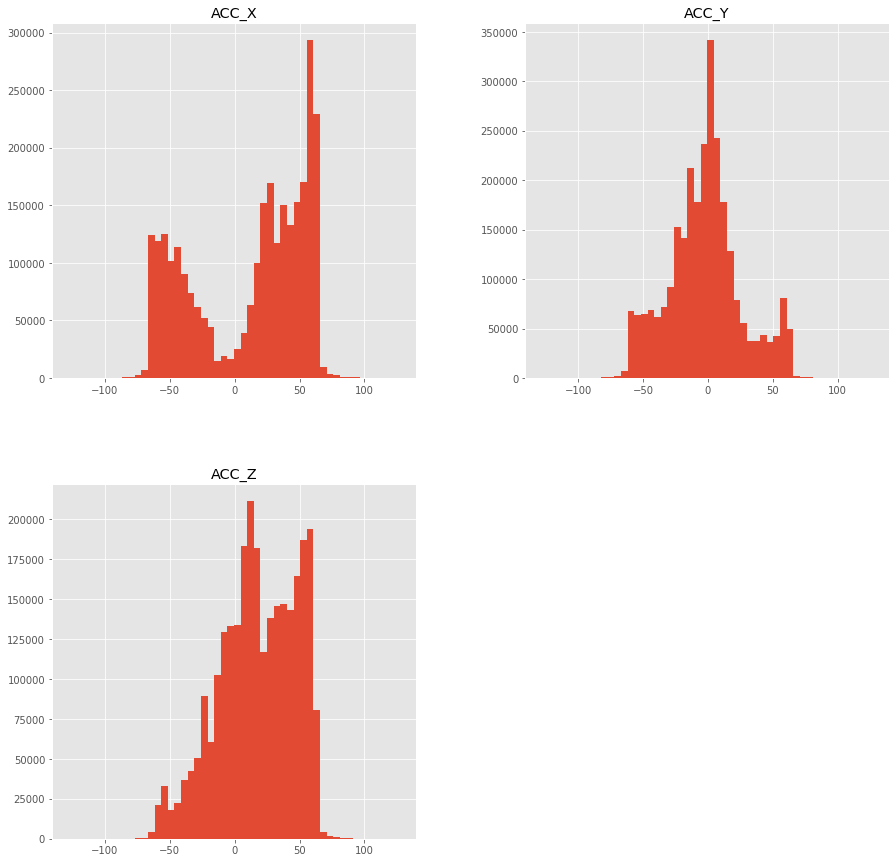

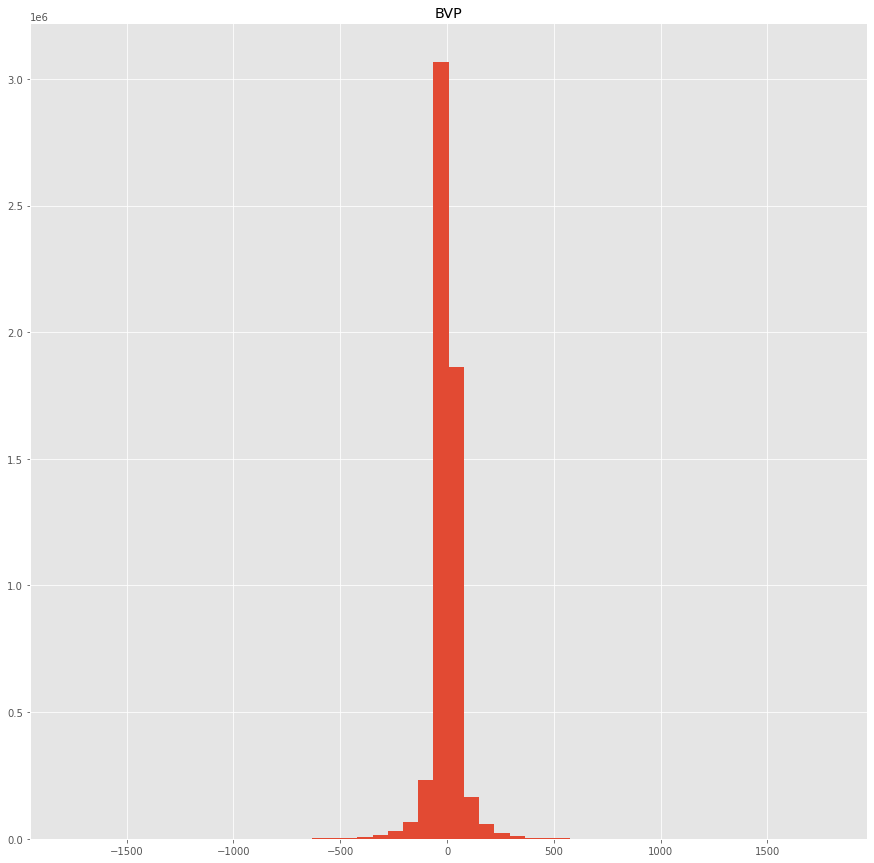

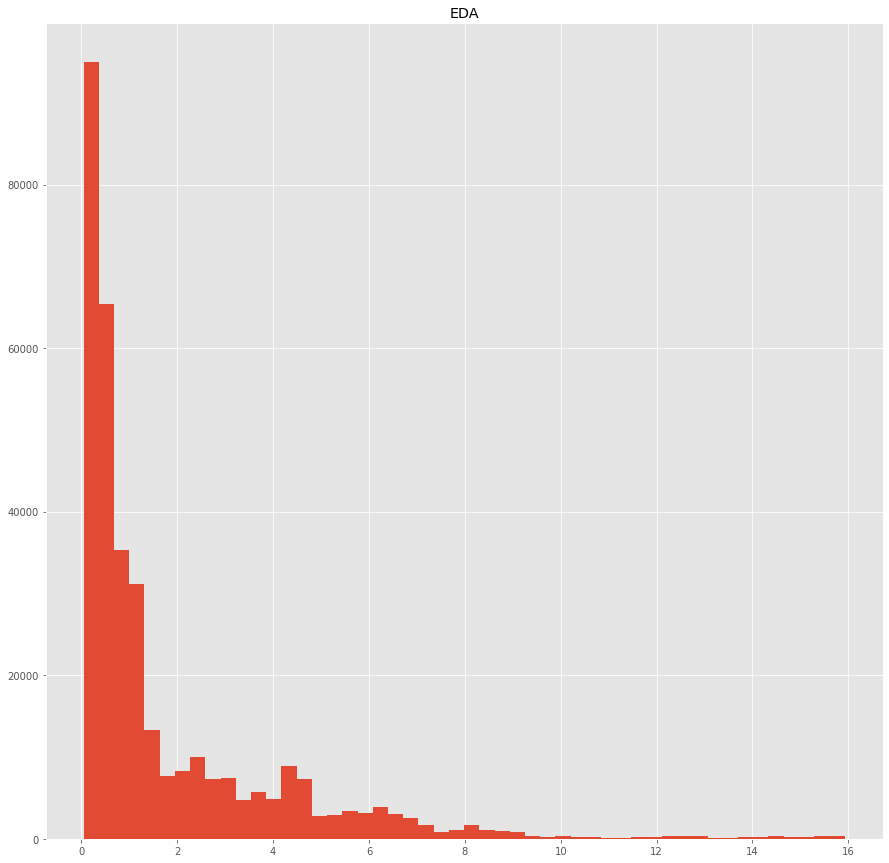

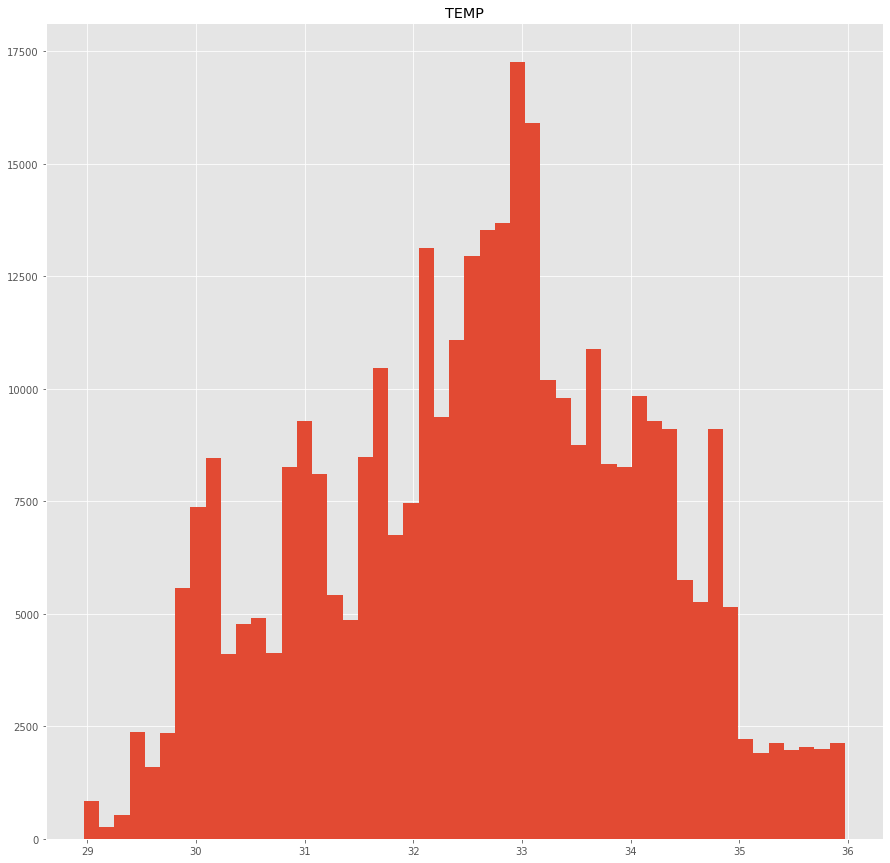

In [14]:
all_subjects_wrist_acc_df.hist(figsize=(15,15),bins=50)
all_subjects_wrist_bvp_df.hist(figsize=(15,15),bins=50)
all_subjects_wrist_eda_df.hist(figsize=(15,15),bins=50)
all_subjects_wrist_temp_df.hist(figsize=(15,15),bins=50)

# Some Observations on the Sensor Data

## Chest DataFrame

- Electrocardiography (ECG): 
  - Nothing too much here, low average values, standard deviation and interquartile range. 
  - This is a measure of heart rate variability, so this suggests that for the most part there was no abormal electrical activity in the heart (we'll look into this more later)
  - **This should be validated by a corresponding low variance in the respitory rate data since heart rate and breathing rate are highly linked**
- Electromyography (EMG): 
  - Nothing much here at all: low average values, standard deviation and interquartile range
- Electrodermal Activity (EDA): 
  - EDA is defined as "transient change in certain electrical properties of the skin, resulting from sweat secretion and sweat gland activity"
  - Here we start to see more variation in the data from the other sensors, although it appears that the data fit between 1 and 10. 
  - This is likely due to the intended exercises in the experiment designed to elicit emotional reponses from the subjects. 
    - There was probably one experiment that was designed to elicit a huge response, while the others were for moderate responses
- Accelerometer (ACC): 
  - Can't tell too much from just the descriptive statistics
    - There was hardly any variation in the data points (low standard deviation and inter quartile range), so the minimum and maximum values were likely outliers. 
  - This should make sense too because this sensor is on the chest so it therefore won't move too much in any one direction unless the participants were all over the place.
- Body Temperature (Celsius):
  - Like the first set of sensors, the variation here is very low and there isn't too much to conclude other than the body temperature of the participants did not seem to vary that much (~33-34 degrees Celsius)
    - The minimum value of -273 does suggest an error in data collection (_or someone's heart is just that cold??_) since this corresponds to absolute zero and the range of acceptable values was 0 - 50 according to the linked datasheets in the paper
- Respitory %: 
  - Healthy amount of variation here; still largely normally distributed  w/ relatively low standard deviation and interquartile range
      - **For the most part validates the observations around heart rate data above**
  - There were likely experiments designed to elicit emotional responses, so the values at the tails likely represent this
- Labels:
  - Order of class by decreasing frequency as follows  (5,6, and 7 should be ignored):
    1. 'not defined/transient'
    2. 'baseline'
    3. 'meditation'
    4. 'stress', 
    5. 'amusement'
  - This is mostly as expected, but looks like the state of meditation is quite frequenct so that is worth a closer look
  
## Wrist DataFrame
 
- Accelerometer (ACC):
  - Much more variation here, likely attributable to being on the wrist and being more prone to large changes in position
      - Worth pointing out that the X direction data is concentrated at the ends while the Y & Z direction data is more normally distributed
        - This means alot of movement was done in one set of directions (i.e. north to south, east to west, etc.)
- BVP (measures from PPG):
  - High overall range of values but graph shows a fairly normal distribution; min and max are likely outliers
  - Don't have enough info on this data type to make any more meaningful conclusions
- Electrodermal Activity (EDA): 
  - We see good variation here but less than in the chest data
    - This is likely due to the fact that the chest worn sensor is more sensitive and will pick up smaller changes in electrical activity on the skin
- Body Temperature:
  - Slightly more variation here than the chest data and centered around lower temperature values, but still largely a tight range of numbers (no funky absolute zeros here)
    - Perhaps since the chest sensor is under a shirt while the wrist device is out in the open

# Some overall assumptions

Based on the above observations let's make a couple assumptions about the data and use other methods to try and prove them wrong:
1. Most of the high respitory rate data occurred during a specific range of values (i.e. during a specific stress experiment).
2. Higher EDA values correlate highly (?) to labels of 'stress' and 'amusement' (and lower correspond to 'meditation' and 'baseline').
3. Most of the changes to the accelerometer data occur during a specific range of values (moving to different areas for experiments)
4. The EDA wrist and EDA chest data are highly correlated per subject (all above 0.5)

# Now let's prove them wrong!!

## Plot Data Directly

In order to get the complete picture and test out the above assumptions, we should plot the data in order to see how it varies across the time period of the experiment. In order to be able to compare each subjects's data in the most intuitive way we will plot all subject data onto one graph. This will allow us to validate or discard some of the early conclusions made above.

**Note: We can do this because we have a limited number of actual subjects in the data; if there were hundreds it wouldn't be practical to graph each subject's data on one graph (instead it would be more appropriate to graph summary statistics)**

## Chest Data + Labels

We're going to have to plot these one by one due to the sheer amount of data for each category. Even the plots below take around half a minute each just to render properly...

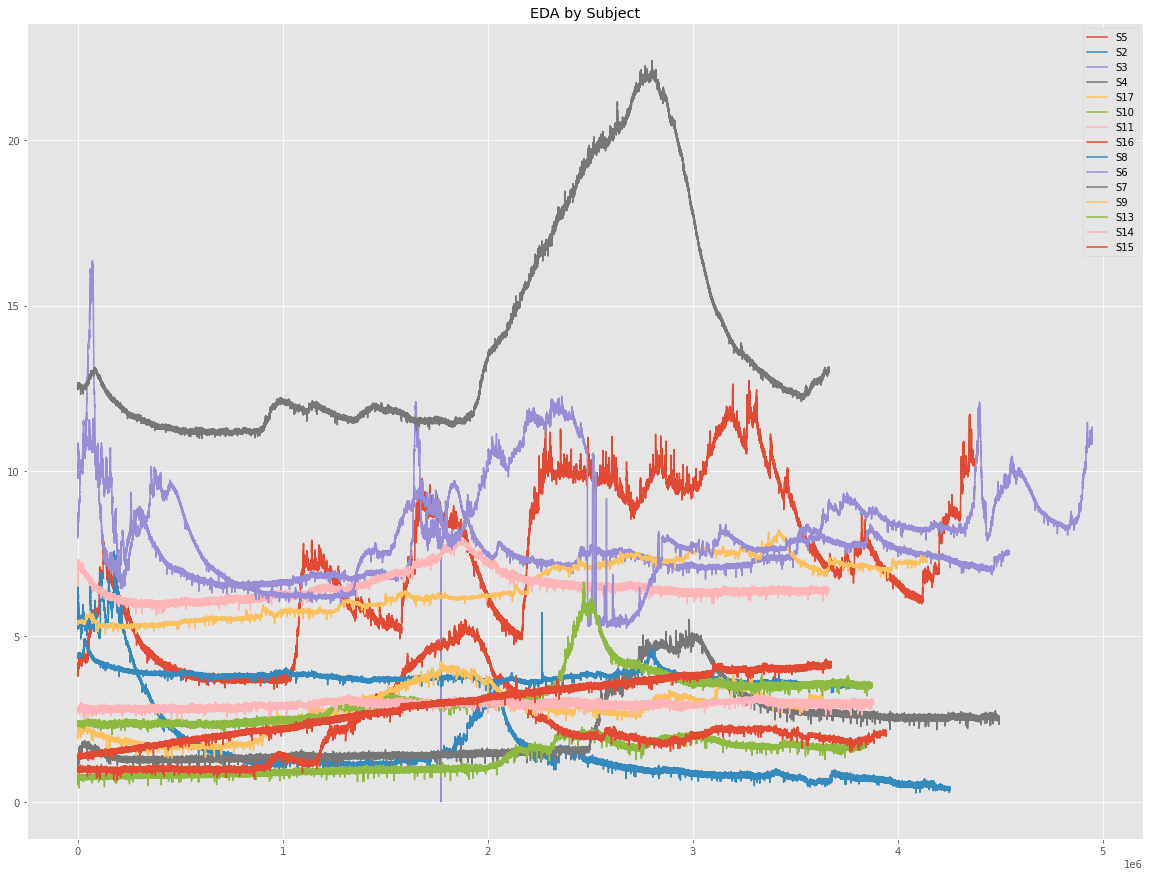

In [16]:
fig, ax = plt.subplots()

for subject in subject_ids:
    subject_dct[subject]['chest_df']['EDA'].plot(figsize = (20,15), label = subject)

ax.legend(subject_ids)
ax.set_title('EDA by Subject')
plt.show()

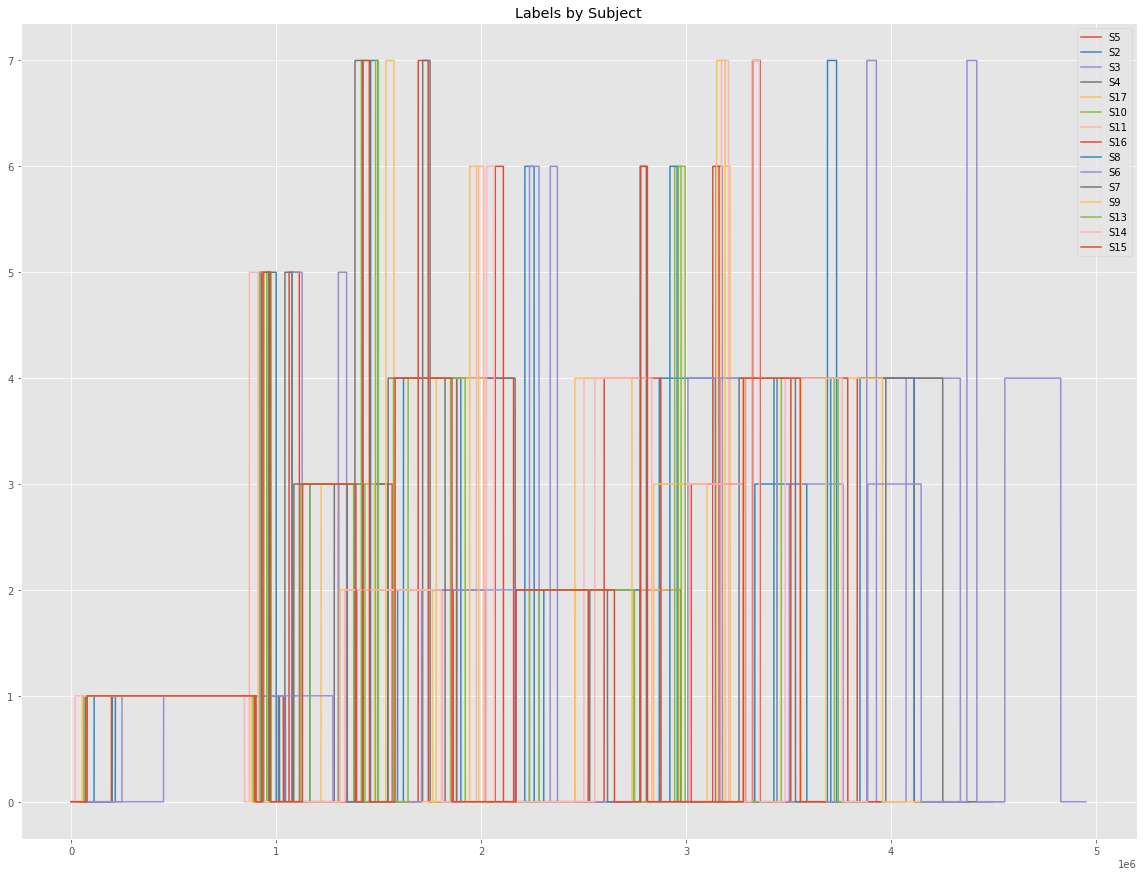

In [110]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['labels']['label'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Labels by Subject')
plt.show()

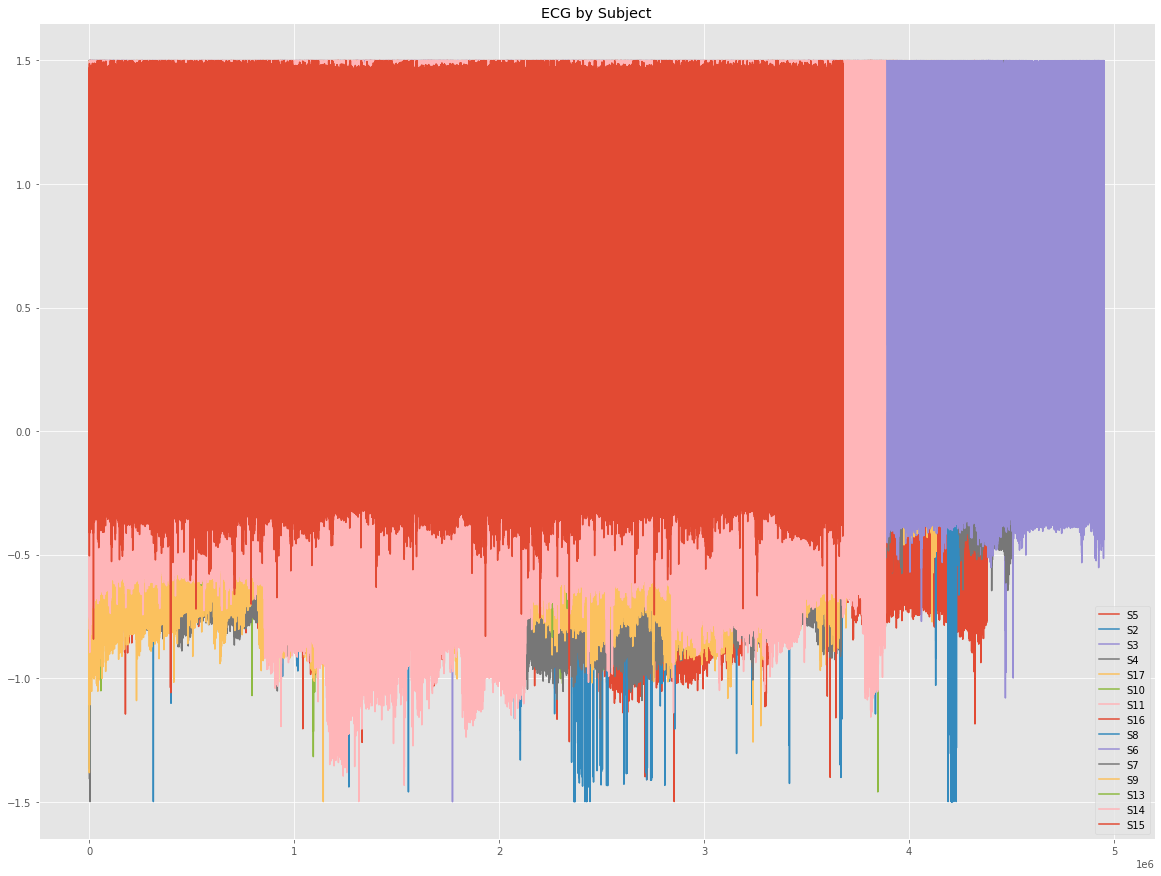

In [17]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['ECG'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('ECG by Subject')
plt.show()

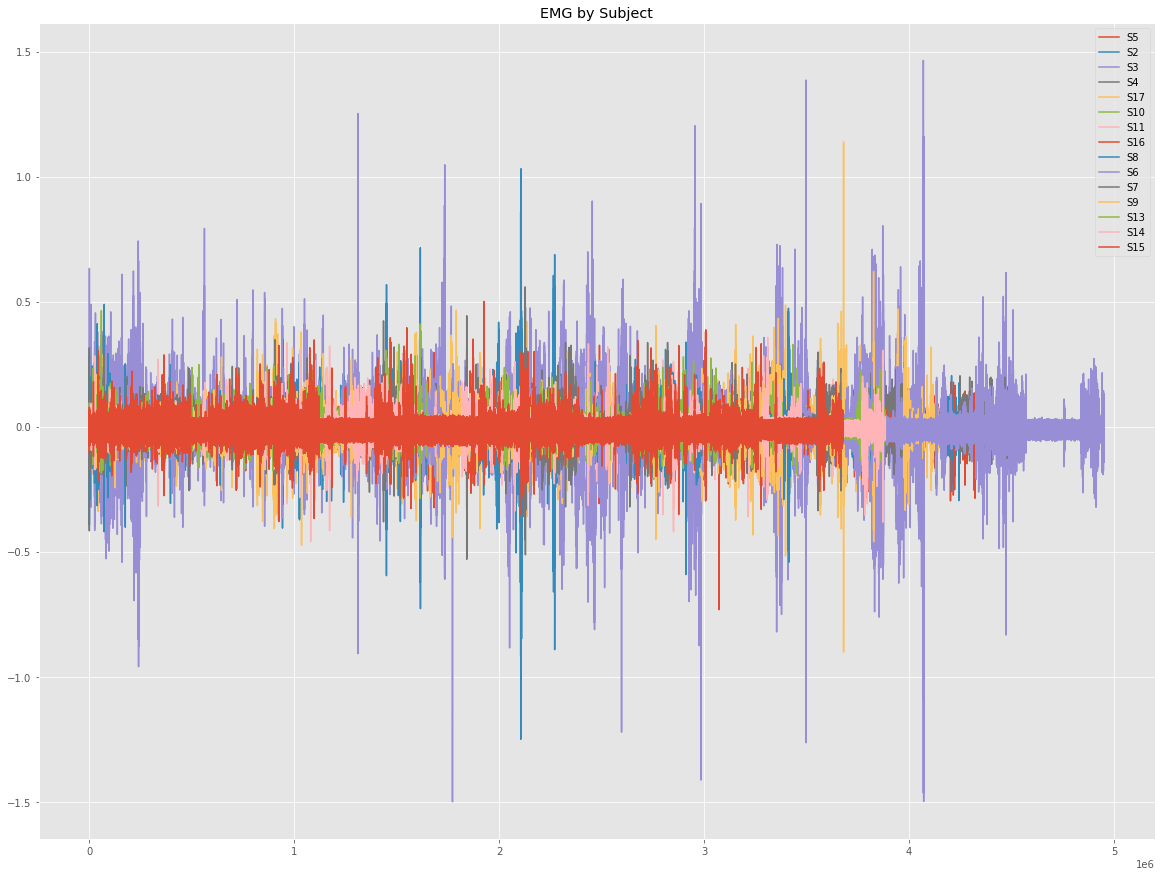

In [18]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['EMG'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('EMG by Subject')
plt.show()

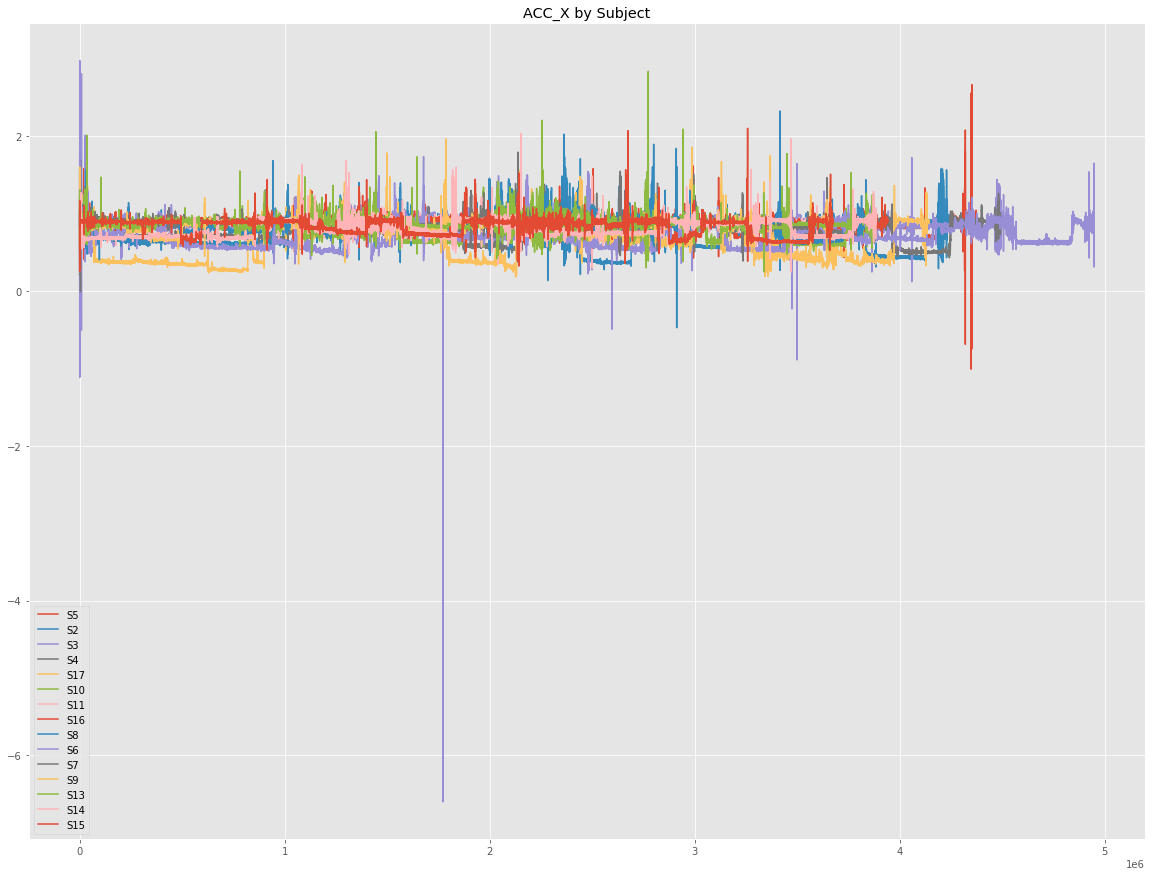

In [19]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['ACC_X'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('ACC_X by Subject')
plt.show()

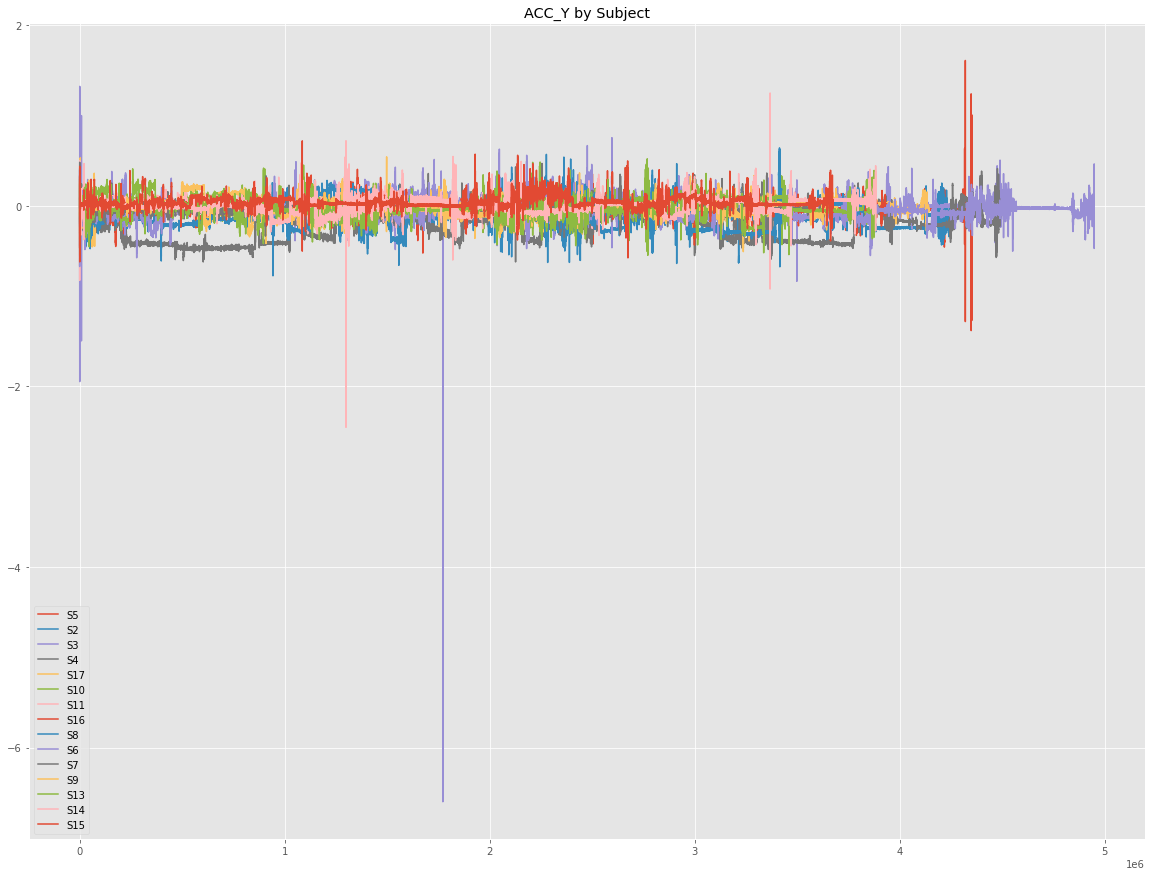

In [20]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['ACC_Y'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('ACC_Y by Subject')
plt.show()

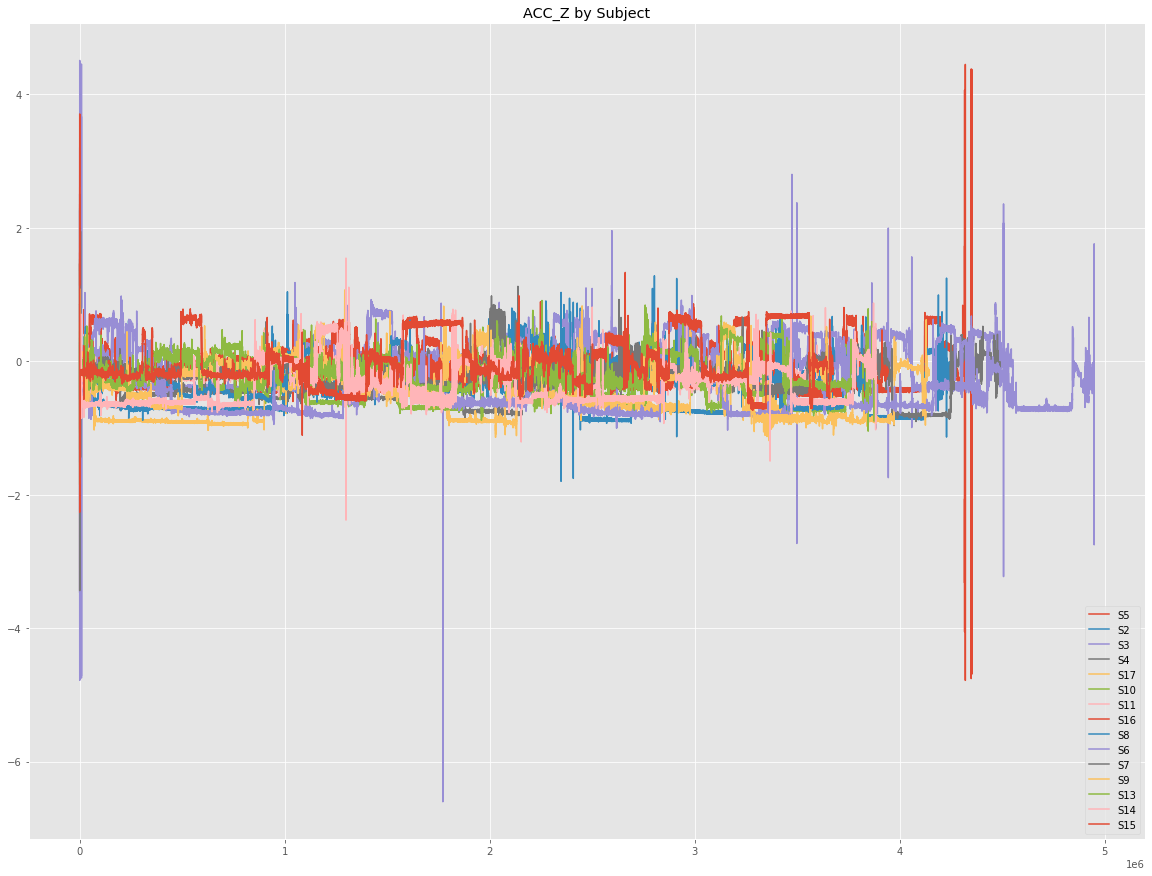

In [21]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['ACC_Z'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('ACC_Z by Subject')
plt.show()

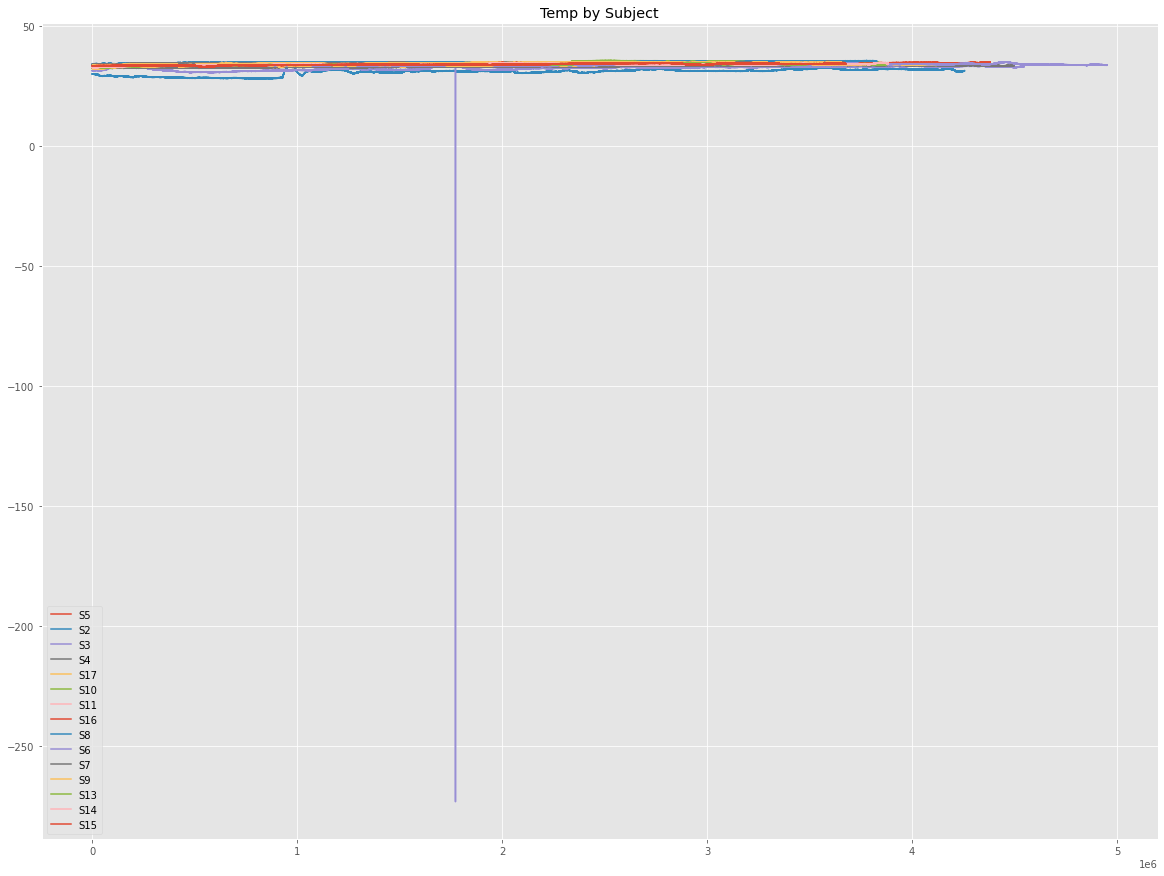

In [22]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['Temp'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Temp by Subject')
plt.show()

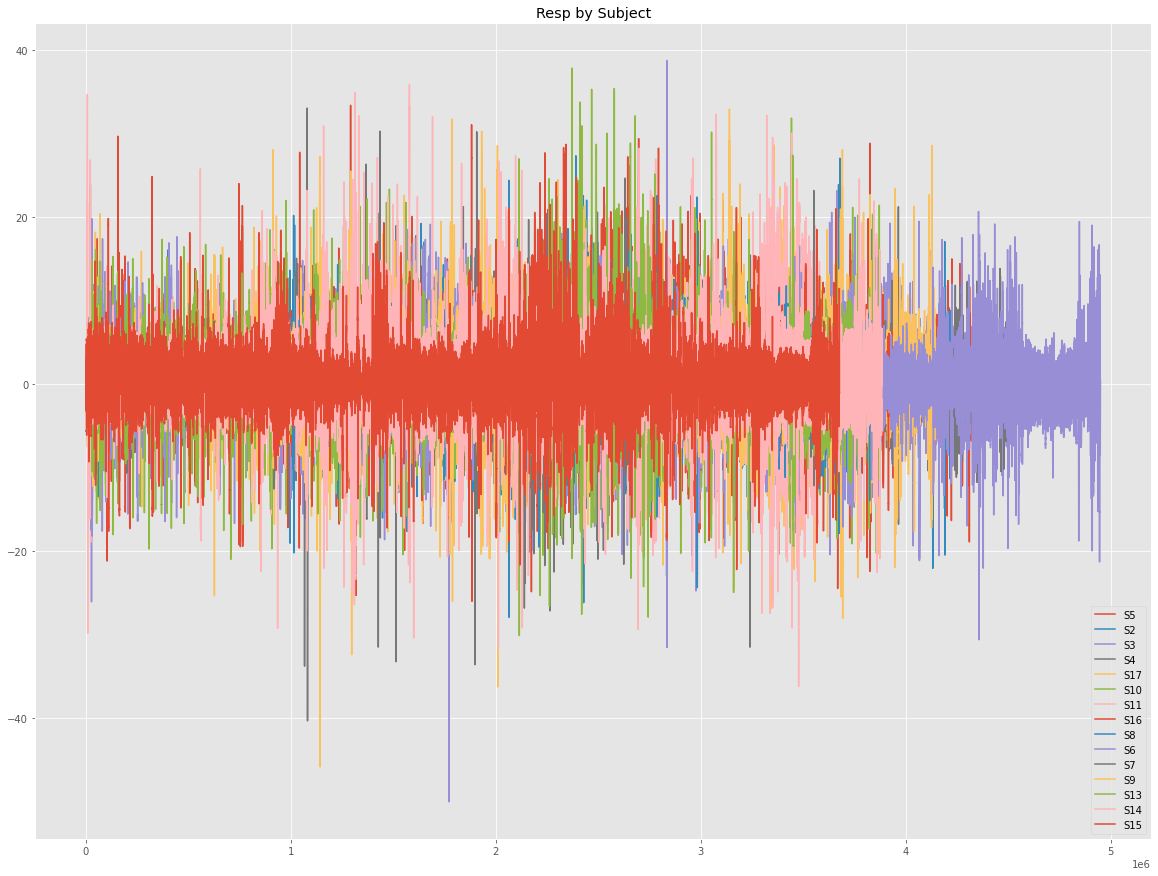

In [23]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['Resp'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Resp by Subject')
plt.show()

## Wrist Data

Here we can go ahead and plot the data all at once and not have to wait too long for the data to render. We'll also be able to see all the graphs much closer together

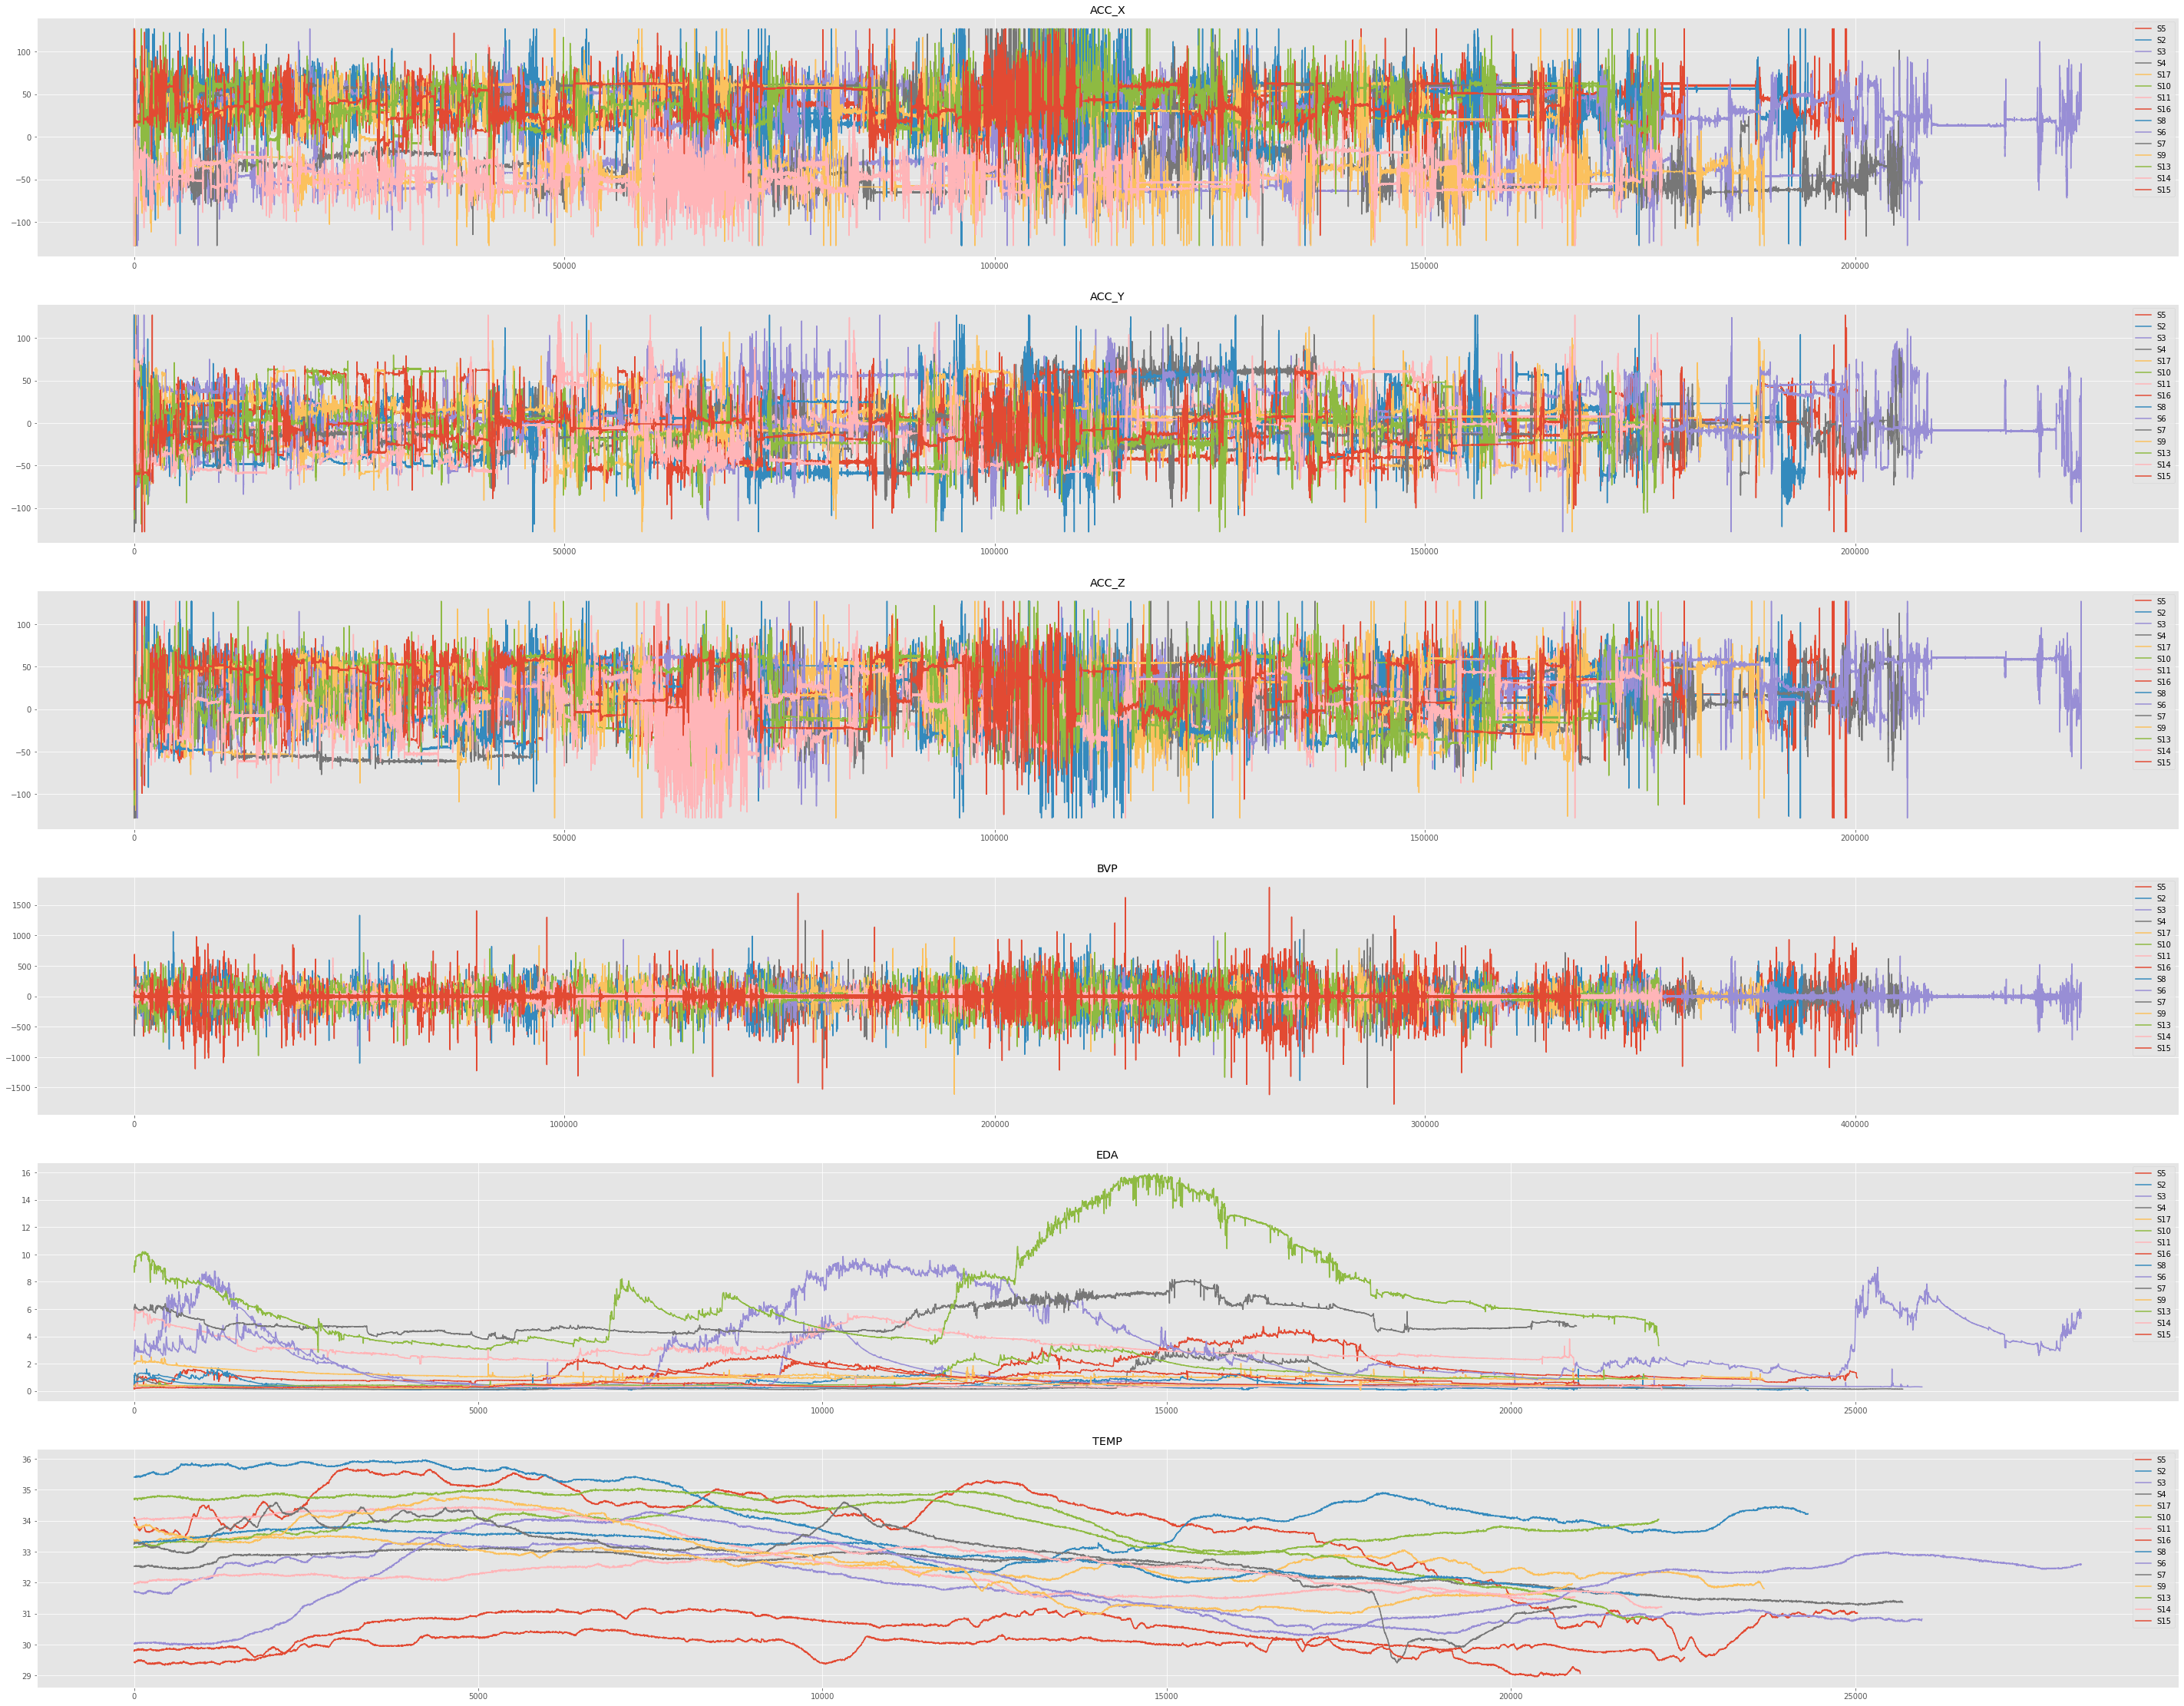

In [24]:
wrist_keys = list(subject_dct[subject]['wrist_dfs'].keys())
fig,axs = plt.subplots(6,1,figsize=(50,40))
for subject in subject_ids:
    # For ACC, need to split out X,Y,Z
    axs[0].plot(subject_dct[subject]['wrist_dfs'][wrist_keys[0]]['ACC_X'])
    axs[0].set_title('ACC_X')
    axs[1].plot(subject_dct[subject]['wrist_dfs'][wrist_keys[0]]['ACC_Y'])
    axs[1].set_title('ACC_Y')
    axs[2].plot(subject_dct[subject]['wrist_dfs'][wrist_keys[0]]['ACC_Z'])
    axs[2].set_title('ACC_Z')
    # Do the rest normally
    axs[3].plot(subject_dct[subject]['wrist_dfs'][wrist_keys[1]].drop(columns='SUBJECT_ID'))
    axs[3].set_title(wrist_keys[1].split('_')[1].upper())
    axs[4].plot(subject_dct[subject]['wrist_dfs'][wrist_keys[2]].drop(columns='SUBJECT_ID'))
    axs[4].set_title(wrist_keys[2].split('_')[1].upper())
    axs[5].plot(subject_dct[subject]['wrist_dfs'][wrist_keys[3]].drop(columns='SUBJECT_ID'))
    axs[5].set_title(wrist_keys[3].split('_')[1].upper())

axs[0].legend(subject_ids)
axs[1].legend(subject_ids)
axs[2].legend(subject_ids)
axs[3].legend(subject_ids)
axs[4].legend(subject_ids)
axs[5].legend(subject_ids)
plt.show()

# Scatter Plots

While the above descriptive statistics are helpful, it may be less clear how features with similar measures (mean, median, standard deviation, etc.) relate to each other (if at all). We should graph these features against each other and see how they relate to each other (negatively/positively, strong/weak, etc.). 

If we end up deciding to try and create a model later, this analysis will help us decide what variables to use and remove.

For this, we will import another visualization packages (seaborn) that has some nicer plotting features and functionalities.

## Chest Data

In [26]:
# Import package and plot correlation
import seaborn as sns

chest_corr = all_subjects_chest_df.corr()
display(chest_corr)

,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z
ECG,1.000,-0.104,-0.000,0.002,0.007,-0.001,0.001,-0.001
EMG,-0.104,1.000,-0.005,0.024,0.001,0.014,-0.003,0.005
EDA,-0.000,-0.005,1.000,0.197,-0.000,0.061,0.136,0.101
Temp,0.002,0.024,0.197,1.000,0.004,0.180,0.235,0.096
Resp,0.007,0.001,-0.000,0.004,1.000,-0.002,-0.003,0.002
ACC_X,-0.001,0.014,0.061,0.180,-0.002,1.000,0.108,0.625
ACC_Y,0.001,-0.003,0.136,0.235,-0.003,0.108,1.000,0.084
ACC_Z,-0.001,0.005,0.101,0.096,0.002,0.625,0.084,1.000


Looks like there isn't much strong correlation here, let's graph it for a better view

In [27]:
# Still alot of variables, but let's give it a go and see what happens
# From https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def plot_sns_heatmap(corr):
    plt.figure(figsize=(14,14))
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

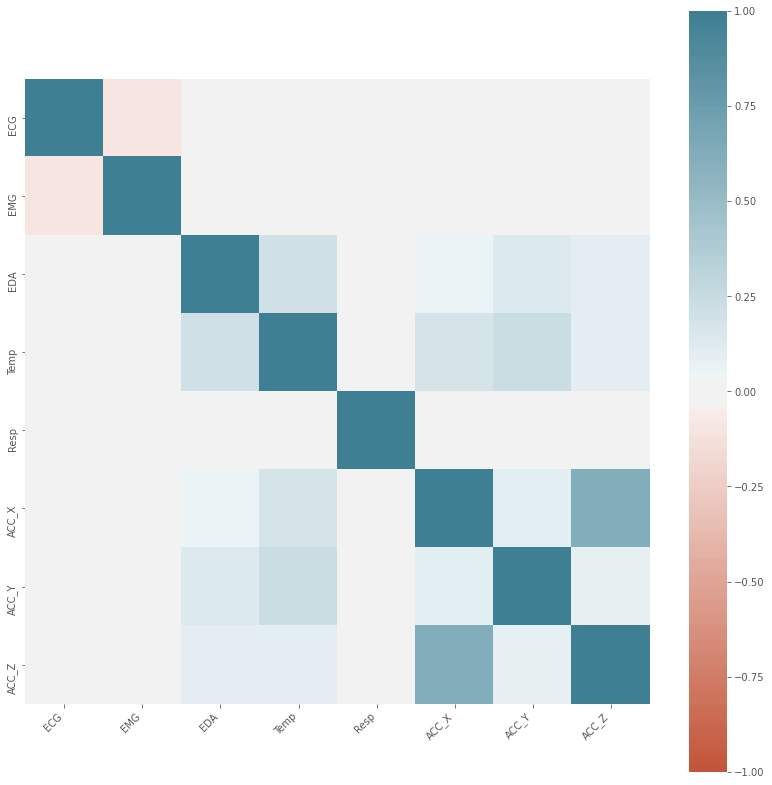

In [28]:
plot_sns_heatmap(chest_corr)

## Wrist Data

## Corresponding Chest + Wrist Data (i.e. Chest EDA vs Wrist EDA)

Obviously comparing the chest and wrist data with different time granularities needs to be taken with a grain of salt but let's try it anyway. I will be doing the correlation on a subject by subject basis to see how the values corresponded.

For this, I will perform some different aggregations to get the chest data onto the same granularity as the wrist. We will certainly lose some information here, but let's see what we find:

In [87]:
# Calculate mean and median first
# Using same idea as here: https://stackoverflow.com/questions/47239332/take-the-sum-of-every-n-rows-in-a-pandas-series
'''
for subject in subject_ids:
    ratio = subject_dct[subject]['chest_df']['EDA'].shape[0] / subject_dct[subject]['wrist_dfs']['wrist_eda_df'].shape[0]
    print('Ratio for subject', subject, 'is', ratio)
'''
corr_dct = {}
combined_dct = {}
N = 175 # Validated by code above
for subject in subject_ids:
    
    # Calculate mean/median for chest data
    df = subject_dct[subject]['chest_df']['EDA']
    mean = pd.DataFrame(df.groupby(df.index // N).mean()).rename(columns={'EDA': 'EDA_CHEST_MEAN'})
    median = pd.DataFrame(df.groupby(df.index // N).median()).rename(columns={'EDA': 'EDA_CHEST_MEDIAN'})
    combined = pd.concat([mean,median],axis=1)
    combined_dct[subject] = combined
    
    # Calculate correlation with wrist data
    chest_df = subject_dct[subject]['wrist_dfs']['wrist_eda_df'].rename(columns={'EDA': 'EDA_WRIST'})
    all_data = pd.concat([chest_df,combined],axis=1)
    corr_dct[subject] = all_data.corr()

In [ ]:
plot_sns_heatmap(corr_dct['S4'])

# Conclusions

We appear to have 